# How the intersubject activity evolves across levels

--- 

Here we're asking the question: How does the intersubject similarity evolve across levels? If we pick a certain region, for a given subject, is the intersubject similarity higher or lower across levels? 

*One prediction is*: if the region is involved in theory updating and learning then we expect a higher similarity for higher levels. As they learn more about the games (i.e. practice) subjects should converge to more similar voxel activation patterns. This might indicate that peoples' representations become more similar (displayed by a larger ISC). In Bayesian terms, people start off with different priors but their posteriors will converge because they get more data. 

--- 

<img src="http://drive.google.com/uc?export=view&id=1aJrScYoDMPCpz__QT3cXItb4GSyEzb2Z" style="height:400px"/>

## Approach

1. We separate the levels betas `[54, voxels]` into 9 arrays of `[games, voxels]`; see image.


```Python

for each [54, voxels] betas data

# take the 1 st item and put together 
# take the 2nd item and append to something
# .... to the 9th item and append

# want: [54, voxels] --> [6 (games), 9 (levels)]

```


2. Plot 9 brain maps (so far this doesn't seem very promising btw)
3. Use the statistical t map to extract the underlying ROIs.
    - plot the r values across levels

```Python
for al ROIs:
    
  # get the most intense voxel in the ROI

  get the x,y,z coordinates that correspond to the highest t statistic
    
  find the voxel that belongs to this x,y,z coordinate

```


4. With the voxel numbers from Momchil, do an ISC analysis as well and plot the r values for all levels


In [33]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio
from scipy import stats

# import own functions
import utils
reload(utils)

#%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

In [36]:
# specify local path
path = '/Users/Daphne/data/'

# load relevant data
levels_betas = np.load(path+'bold_data_levels.npy')

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
mask_mat = mask_arr[0] # so we can pick any one from the array
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows

# mask_nii is the functional mask, this selects the brain voxels
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 

# we get the brain mask (boolean array) with the .dataobj method
brain_mask = np.array(mask_nii.dataobj)

# Get the list of nonzero voxel coordinates from the nii mask
coords_nii = np.where(brain_mask)

# this where we plot our mask ON (sometimes called brain_nii) - the anatomical/structural image
mean_nii = nib.load(os.path.join(path, 'mean.nii')) 

# Uncomment to sanity check (takes long to load)

In [35]:
#df_levels_betas = pd.read_csv(path+'ordered_betas_df_levels.c
# game_names = df_levels_betas['game'].values
# game_levels = df_levels_betas['level'].values

# print(game_names[0:9])
# print(game_levels[0:9])
# print(len(game_levels))

In [14]:
# get every 1st item (all levels 1)
# game_levels[0::9]

In [15]:
# game_names[0::9]

In [16]:
# take one subject 
s = 0
levels_betas_sub = levels_betas[:,:,s]
levels_betas.shape

(54, 220075, 8)

## 1. Separate data into `9` arrays of  `[6,20075,8] = [games, voxels, subjects]`

In [37]:
betas_level_one = []
betas_level_two = []
betas_level_three = []
betas_level_four = []
betas_level_five = []
betas_level_six = []
betas_level_seven = []
betas_level_eight = []
betas_level_nine = []

num_subjects = 8

for s in range(num_subjects):
    #print(s)
    # take the array for that subject 
    levels_betas_sub = levels_betas[:,:,s]
    
    # level 1
    lvl_one_betas_sub = levels_betas_sub[0::9]
    betas_level_one.append(lvl_one_betas_sub)
    
    # level 2
    lvl_two_betas_sub = levels_betas_sub[1::9]
    betas_level_two.append(lvl_two_betas_sub)
    
    # level 3
    lvl_three_betas_sub = levels_betas_sub[2::9]
    betas_level_three.append(lvl_three_betas_sub)
    
    # level 4
    lvl_four_betas_sub = levels_betas_sub[3::9]
    betas_level_four.append(lvl_four_betas_sub)
    
    # level 5
    lvl_five_betas_sub = levels_betas_sub[4::9]
    betas_level_five.append(lvl_five_betas_sub)
    
    # level 6
    lvl_six_betas_sub = levels_betas_sub[5::9]
    betas_level_six.append(lvl_six_betas_sub)
    
    # level 7
    lvl_seven_betas_sub = levels_betas_sub[6::9]
    betas_level_seven.append(lvl_seven_betas_sub)
    
    # level 8
    lvl_eight_betas_sub = levels_betas_sub[7::9]
    betas_level_eight.append(lvl_eight_betas_sub)
    
    # level 9
    lvl_nine_betas_sub = levels_betas_sub[8::9]
    betas_level_nine.append(lvl_nine_betas_sub)
    
# convert lists to np arrays
betas_level_one = np.array(betas_level_one)
betas_level_two = np.array(betas_level_two)
betas_level_three = np.array(betas_level_three)
betas_level_four = np.array(betas_level_four)
betas_level_five = np.array(betas_level_five)
betas_level_six = np.array(betas_level_six)
betas_level_seven = np.array(betas_level_seven)
betas_level_eight = np.array(betas_level_eight)
betas_level_nine = np.array(betas_level_nine)

In [38]:
betas_level_one.shape # [subjects, games, voxels]

(8, 6, 220075)

## 2. Swapaxes to get data in the right shape

In [39]:
# do isc for each level
# compute the isc correlations using the leave one out approach
betas_level_one = np.swapaxes(betas_level_one, 0, 1) # need to get [TRs, voxels, subjects]
betas_level_one = np.swapaxes(betas_level_one, 1, 2)

betas_level_two = np.swapaxes(betas_level_two, 0, 1) # need to get [TRs, voxels, subjects]
betas_level_two = np.swapaxes(betas_level_two, 1, 2)

betas_level_three = np.swapaxes(betas_level_three, 0, 1) # need to get [TRs, voxels, subjects]
betas_level_three = np.swapaxes(betas_level_three, 1, 2)

betas_level_four = np.swapaxes(betas_level_four, 0, 1) # need to get [TRs, voxels, subjects]
betas_level_four = np.swapaxes(betas_level_four, 1, 2)

betas_level_five = np.swapaxes(betas_level_five, 0, 1) # need to get [TRs, voxels, subjects]
betas_level_five = np.swapaxes(betas_level_five, 1, 2)

betas_level_six = np.swapaxes(betas_level_six, 0, 1) # need to get [TRs, voxels, subjects]
betas_level_six = np.swapaxes(betas_level_six, 1, 2)

betas_level_seven = np.swapaxes(betas_level_seven, 0, 1) # need to get [TRs, voxels, subjects]
betas_level_seven = np.swapaxes(betas_level_seven, 1, 2)

betas_level_eight = np.swapaxes(betas_level_eight, 0, 1) # need to get [TRs, voxels, subjects]
betas_level_eight = np.swapaxes(betas_level_eight, 1, 2)

betas_level_nine = np.swapaxes(betas_level_nine, 0, 1) # need to get [TRs, voxels, subjects]
betas_level_nine = np.swapaxes(betas_level_nine, 1, 2)

In [40]:
print(betas_level_one.shape)
betas_level_two.shape # [all games, voxels, subjects]

(6, 220075, 8)


(6, 220075, 8)

## 3. ISC for all voxels and plot brain maps

Row or column wise?

- column wise (voxels): We do the exact same analysis but then with the betas separated in levels. We ask: for each voxel, how similar are the voxel intensities for level $k$ from one person compared to the average of the other peopele (for all games). 

---

**Note.** `isc_maps_lvl_[...]` are the `r coefficients`.

---

In [41]:
isc_maps_lvl_one = isc(betas_level_one, pairwise=False, tolerate_nans=True)
isc_maps_lvl_two = isc(betas_level_two, pairwise=False, tolerate_nans=True)
isc_maps_lvl_three = isc(betas_level_three, pairwise=False, tolerate_nans=True)
isc_maps_lvl_four = isc(betas_level_four, pairwise=False, tolerate_nans=True)
isc_maps_lvl_five = isc(betas_level_five, pairwise=False, tolerate_nans=True)
isc_maps_lvl_six = isc(betas_level_six, pairwise=False, tolerate_nans=True)
isc_maps_lvl_seven = isc(betas_level_seven, pairwise=False, tolerate_nans=True)
isc_maps_lvl_eight = isc(betas_level_eight, pairwise=False, tolerate_nans=True)
isc_maps_lvl_nine = isc(betas_level_nine, pairwise=False, tolerate_nans=True)

In [42]:
isc_maps_lvl_one.shape

(8, 220075)

# Maps (isc with all voxels)


## Level 1

In [43]:
tstats, p = stats.ttest_1samp(np.arctanh(isc_maps_lvl_one), popmean=0)

Display t statistics with a corresponding p < 0.01


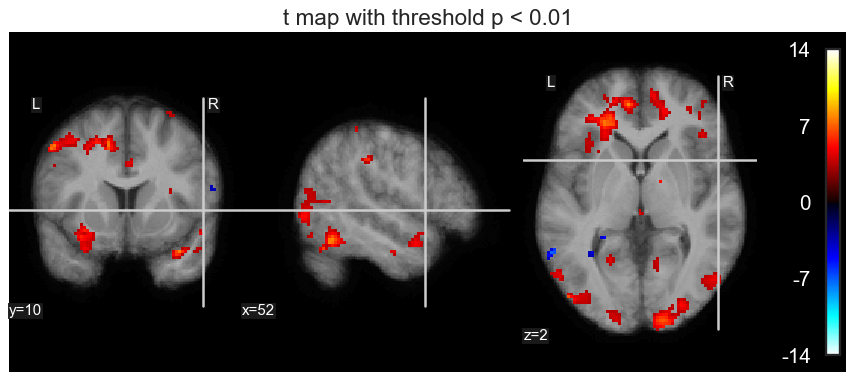

In [44]:
utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats, 
                           pvalues=p, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

## Level 2

Display t statistics with a corresponding p < 0.01


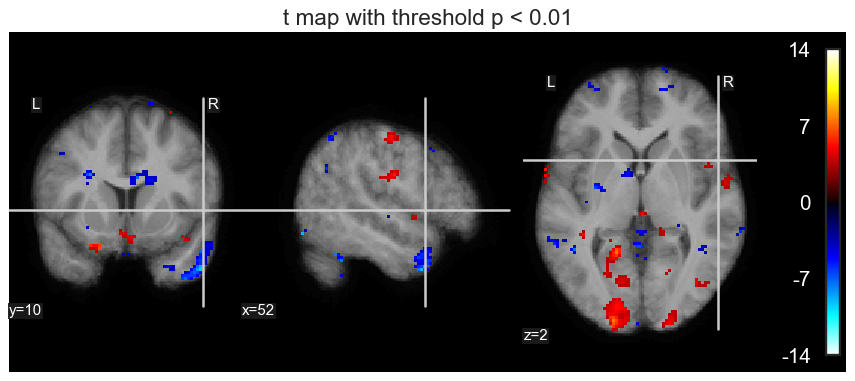

In [45]:
tstats, p = stats.ttest_1samp(np.arctanh(isc_maps_lvl_two), popmean=0)

utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats, 
                           pvalues=p, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

## Level 3

Display t statistics with a corresponding p < 0.01


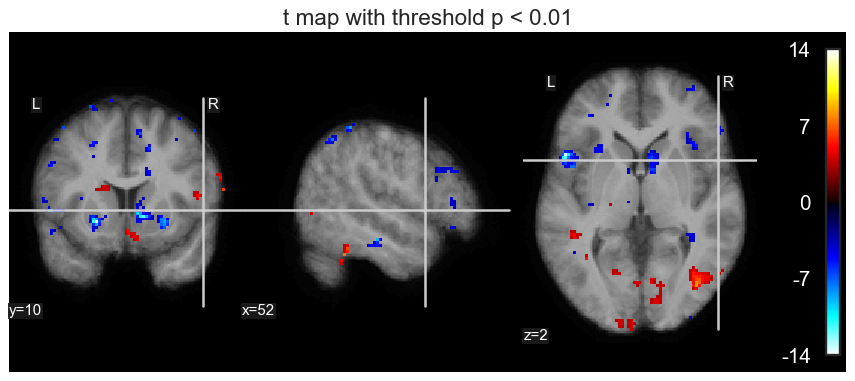

In [46]:
tstats, p = stats.ttest_1samp(np.arctanh(isc_maps_lvl_three), popmean=0)

utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats, 
                           pvalues=p, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

## Level 4

Display t statistics with a corresponding p < 0.01


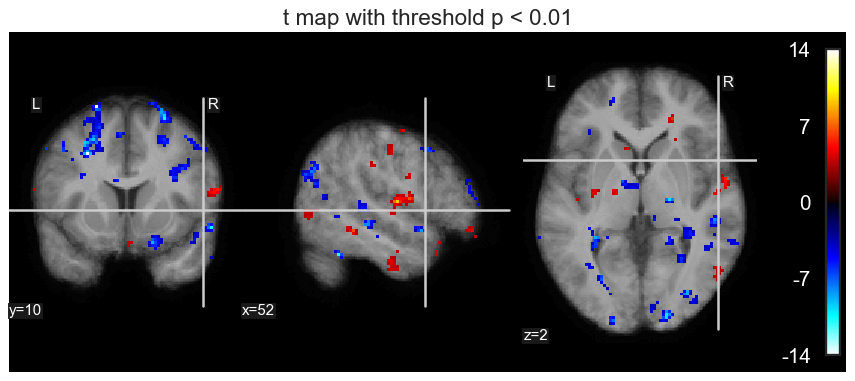

In [47]:
tstats, p = stats.ttest_1samp(np.arctanh(isc_maps_lvl_four), popmean=0)

utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats, 
                           pvalues=p, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

## Level 5

Display t statistics with a corresponding p < 0.01


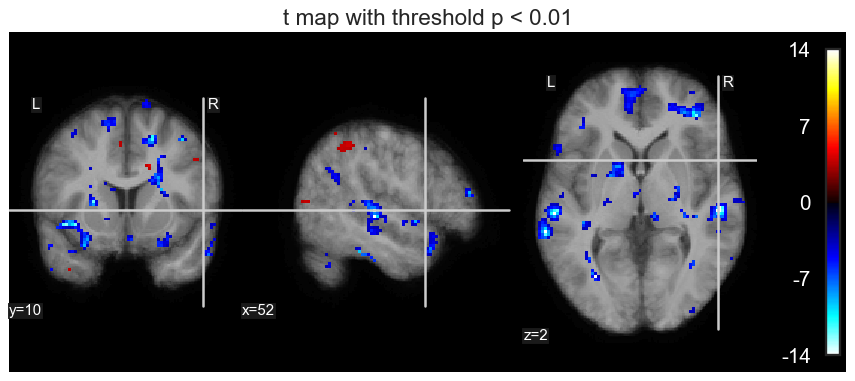

In [48]:
tstats, p = stats.ttest_1samp(np.arctanh(isc_maps_lvl_five), popmean=0)

utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats, 
                           pvalues=p, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

## Level 6

Display t statistics with a corresponding p < 0.01


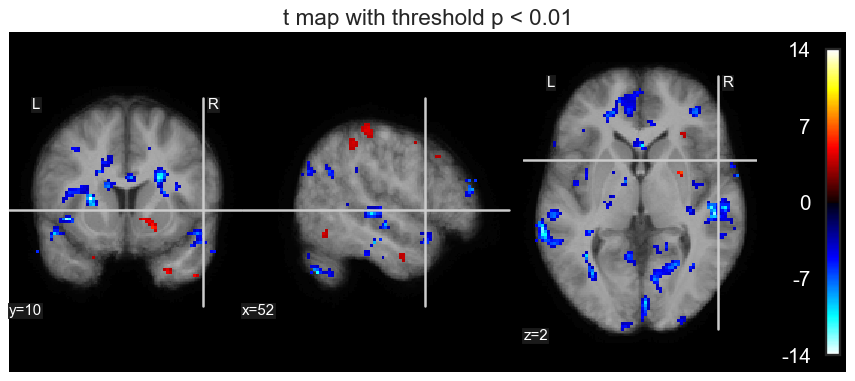

In [49]:
tstats, p = stats.ttest_1samp(np.arctanh(isc_maps_lvl_six), popmean=0)

utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats, 
                           pvalues=p, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

## Level 7

Display t statistics with a corresponding p < 0.01


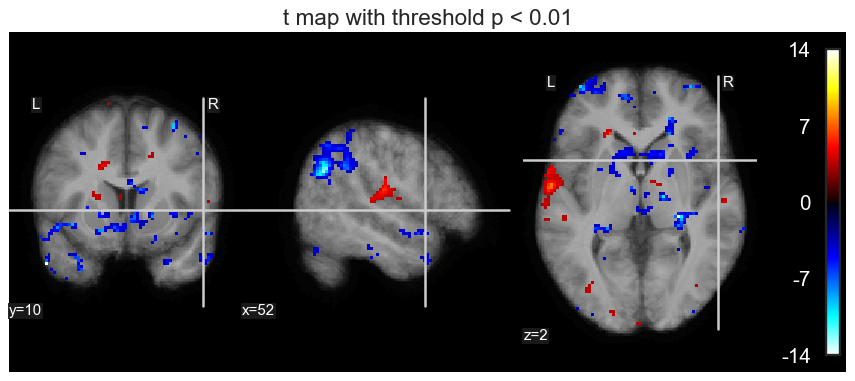

In [50]:
tstats, p = stats.ttest_1samp(np.arctanh(isc_maps_lvl_seven), popmean=0)

utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats, 
                           pvalues=p, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

## Level 8

Display t statistics with a corresponding p < 0.01


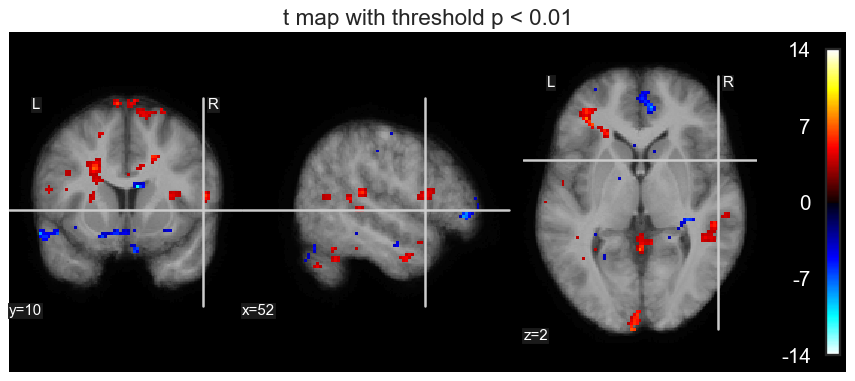

In [51]:
tstats, p = stats.ttest_1samp(np.arctanh(isc_maps_lvl_eight), popmean=0)

utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats, 
                           pvalues=p, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

## Level 9

Display t statistics with a corresponding p < 0.01


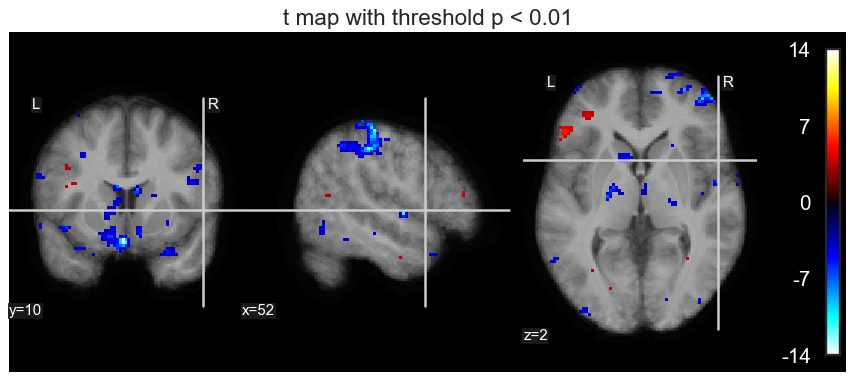

In [52]:
tstats, p = stats.ttest_1samp(np.arctanh(isc_maps_lvl_nine), popmean=0)

utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats, 
                           pvalues=p, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

Display t statistics with a corresponding p < 0.01


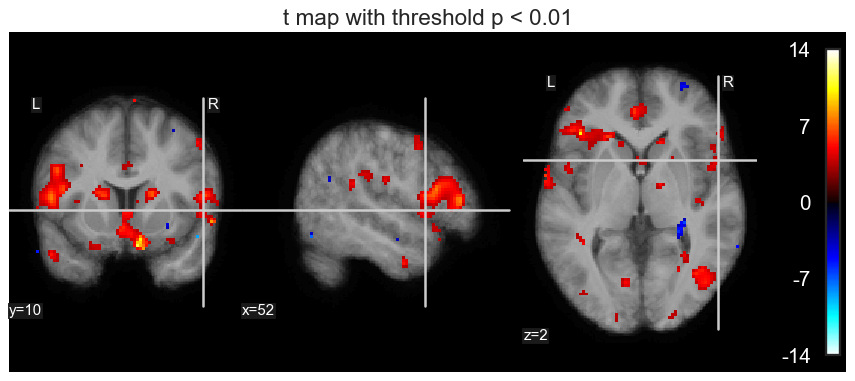

In [53]:
# remember we got 
iscs_r_levels = np.load(path+'iscs_r_levels.npy')
tstats_levels, p_levels = stats.ttest_1samp(np.arctanh(iscs_r_levels), popmean=0)

# plot the t map and store the nifti image as the statistical image
stat_img = utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats_levels, 
                           pvalues=p_levels, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=14)

In [54]:
stat_img # .nii file

In [55]:
view = plotting.view_img(stat_img, threshold=.2)


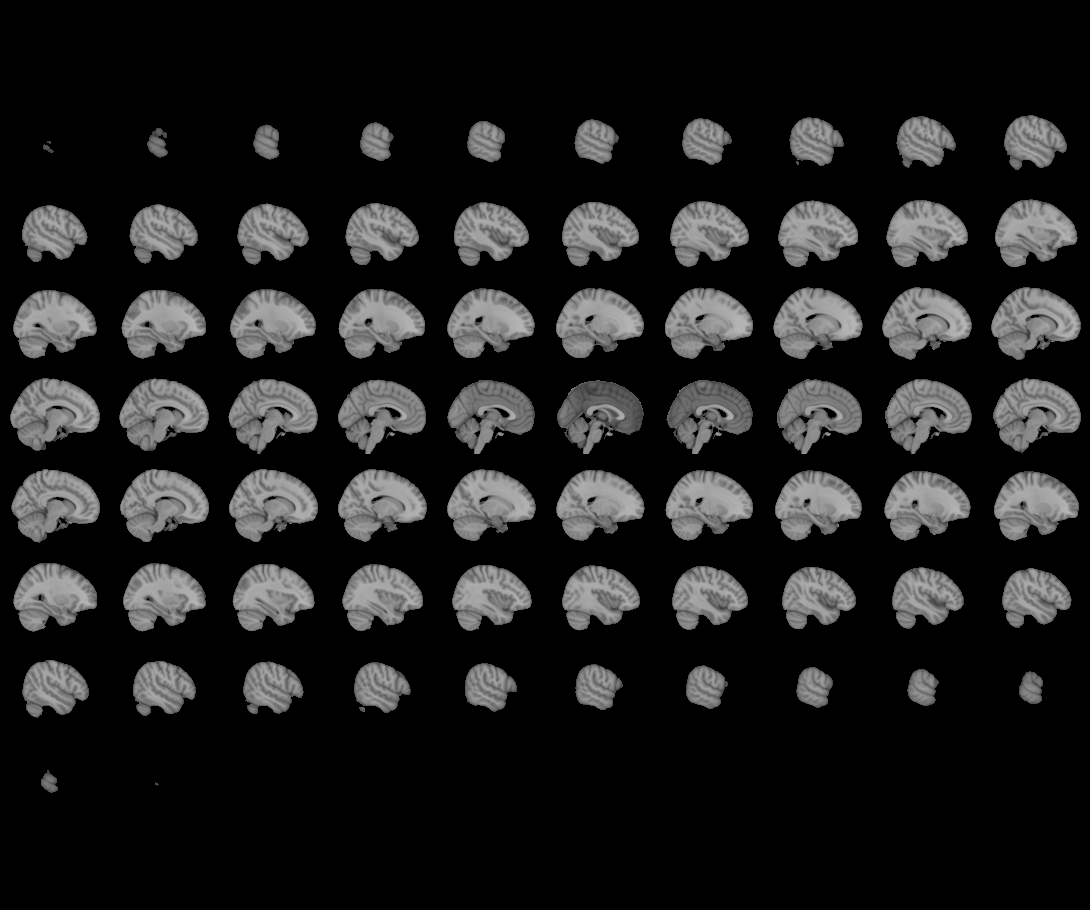
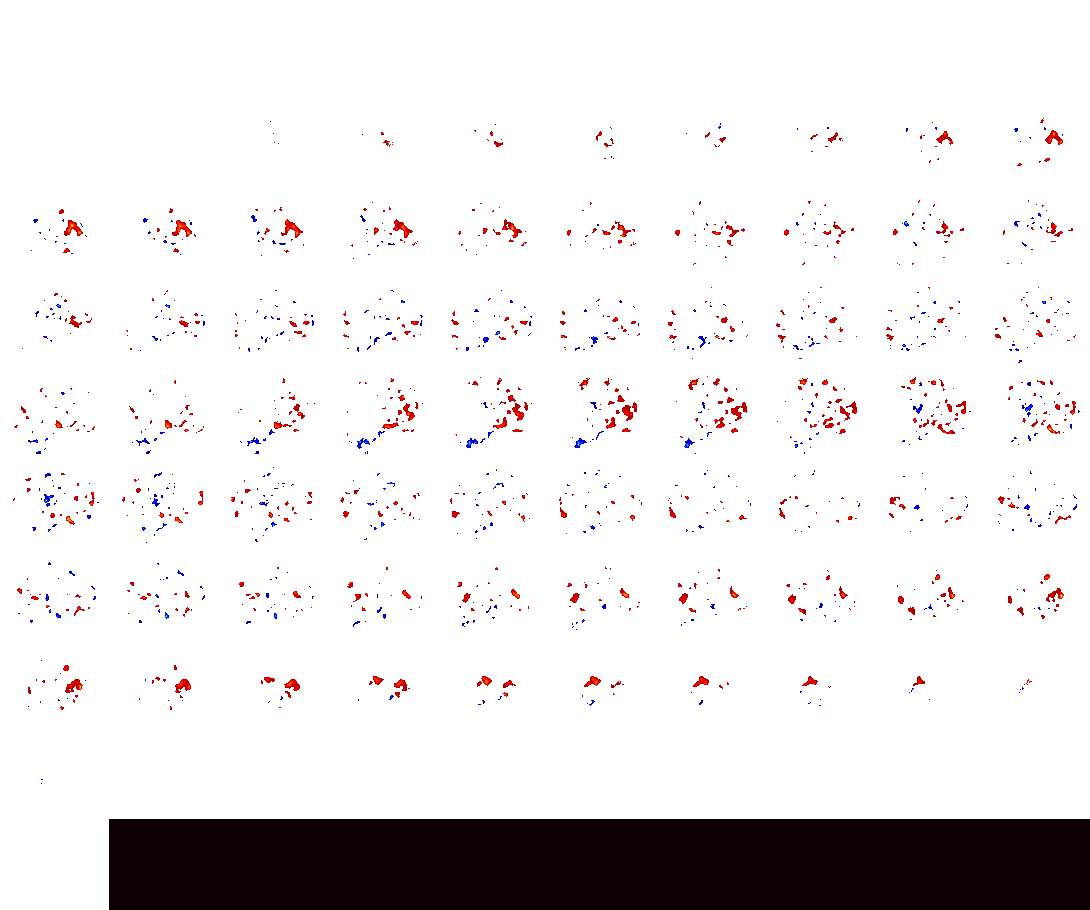

In [56]:
view 

# Option 1. Region Extraction using a t-statistical map (3D) 

In [57]:
from nilearn.image import threshold_img
from nilearn.regions import connected_regions

# threshold the t-statistic image by importing threshold function
threshold_value_img = threshold_img(stat_img, threshold='95%', copy=False)

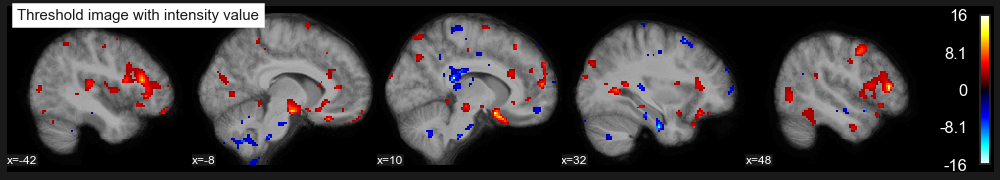

In [58]:
# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, bg_img=mean_nii, display_mode='x', cut_coords=5,
                       title='Threshold image with intensity value', colorbar=True);

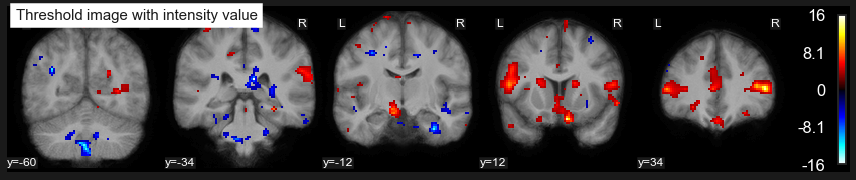

In [59]:
# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, bg_img=mean_nii, display_mode='y', cut_coords=5,
                       title='Threshold image with intensity value', colorbar=True);

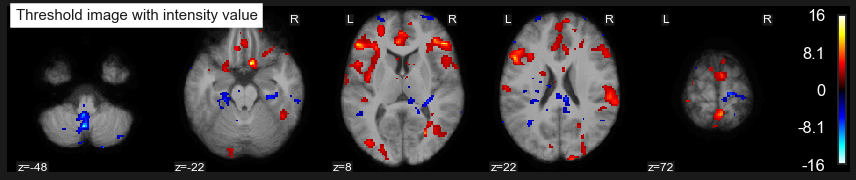

In [60]:
# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, bg_img=mean_nii, display_mode='z', cut_coords=5,
                       title='Threshold image with intensity value', colorbar=True);

In [61]:
regions_extracted_img, index = connected_regions(threshold_value_img,
                                                 min_region_size=1350)

In [62]:
title = ("ROIs using image intensity thresholding. "
         "\n Each ROI in same color is an extracted region")
plotting.plot_prob_atlas(regions_value_img, bg_img=mean_nii,
                         view_type='contours', display_mode='x',
                         cut_coords=5, title=title);

NameError: name 'regions_value_img' is not defined

In [ ]:
plotting.plot_prob_atlas(regions_value_img, bg_img=mean_nii,
                         view_type='contours', display_mode='y',
                         cut_coords=5);

In [ ]:
plotting.plot_prob_atlas(regions_value_img, bg_img=mean_nii,
                         view_type='contours', display_mode='z',
                         cut_coords=5);

In [ ]:
index

In [ ]:
regions_extracted_img.shape

In [ ]:
regions_extracted_img

In [ ]:
# extract the masks using .dataobj (boolean arrs) 
roi_mask_one = regions_extracted_img.dataobj[:,:,:,0]
roi_mask_two = regions_extracted_img.dataobj[:,:,:,1]
roi_mask_three = regions_extracted_img.dataobj[:,:,:,2]
roi_mask_four = regions_extracted_img.dataobj[:,:,:,3]
roi_mask_five = regions_extracted_img.dataobj[:,:,:,4]
roi_mask_six = regions_extracted_img.dataobj[:,:,:,5]

roi_mask_one.shape

In [ ]:
# convert to nifti object to plot
roi_mask_nifti_one = nib.Nifti1Image(roi_mask_one, regions_extracted_img.affine, regions_extracted_img.header) 

# The mask_nii mask overlayed on mean_nii
plotting.plot_roi(roi_img=roi_mask_nifti_one, bg_img=mean_nii, black_bg=False);

In [ ]:
# convert to nifti object to plot
roi_mask_nifti_two = nib.Nifti1Image(roi_mask_two, regions_extracted_img.affine, regions_extracted_img.header) 

# The mask_nii mask overlayed on mean_nii
plotting.plot_roi(roi_img=roi_mask_nifti_two, bg_img=mean_nii, black_bg=False);

In [ ]:
# convert to nifti object to plot
roi_mask_nifti_three = nib.Nifti1Image(roi_mask_three, regions_extracted_img.affine, regions_extracted_img.header) 

# The mask_nii mask overlayed on mean_nii
plotting.plot_roi(roi_img=roi_mask_nifti_three, bg_img=mean_nii, black_bg=False);

In [ ]:
# convert to nifti object to plot
roi_mask_nifti_four = nib.Nifti1Image(roi_mask_four, regions_extracted_img.affine, regions_extracted_img.header) 

# The mask_nii mask overlayed on mean_nii
plotting.plot_roi(roi_img=roi_mask_nifti_four, bg_img=mean_nii, black_bg=False);

In [ ]:
# convert to nifti object to plot
roi_mask_nifti_five = nib.Nifti1Image(roi_mask_five, regions_extracted_img.affine, regions_extracted_img.header) 

# The mask_nii mask overlayed on mean_nii
plotting.plot_roi(roi_img=roi_mask_nifti_five, bg_img=mean_nii, black_bg=False);

In [ ]:
# convert to nifti object to plot
roi_mask_nifti_six = nib.Nifti1Image(roi_mask_six, regions_extracted_img.affine, regions_extracted_img.header) 

# The mask_nii mask overlayed on mean_nii
plotting.plot_roi(roi_img=roi_mask_nifti_six, bg_img=mean_nii, black_bg=False);

# Take the top voxel of each of these masks (roi's)

In [ ]:
zeros_vol = np.zeros(roi_mask_one.shape) # make zeros volume
 
top_vox = max(np.unique(roi_mask_one)) # this is the max t statistic

In [ ]:
roi_mask_one.shape

In [ ]:
top_vox_coords = np.where(roi_mask_one==top_vox) # get x,y,z coords for top voxel

print(top_vox_coords) # these are the coordinates

In [ ]:
int(top_vox_coords[0])

## Now, these are coordinates in the mni space? (are they????). So we want to translate this coordinate to voxel space in order to find the right corresponding voxel

[image.coord_transform](https://nilearn.github.io/modules/generated/nilearn.image.coord_transform.html)

In [ ]:
from nilearn import image

x_mni = int(top_vox_coords[0])
y_mni = int(top_vox_coords[1])
z_mni = int(top_vox_coords[2])

print(x_mni,y_mni,z_mni)

# transform from mni to voxel space 
voxel_space_coords = image.coord_transform(x_mni, y_mni, z_mni, regions_extracted_img.affine)

print(voxel_space_coords)

This is probably a stupid way to find the corresponding voxel but ok...


In [ ]:
int(voxel_space_coords[0])

In [ ]:
for v in range(len(all_vox_coords[0])):
    
    # x,y,z arrays are
    x_arr = all_vox_coords[0, :]
    y_arr = all_vox_coords[1, :]
    z_arr = all_vox_coords[2, :]
    
    # take coordinates for voxel v
    x = x_arr[v]
    y = y_arr[v]
    z = z_arr[v]

#     if x == int(voxel_space_coords[0]) and y == int(voxel_space_coords[1]) and z == int(voxel_space_coords[2]):
#         print(f'The coordinates correspond to voxel: {v}. Take the betas for this voxel to do your ISC!')

    if x == int(top_vox_coords[0]) and y == int(top_vox_coords[1]) and z == int(top_vox_coords[2]):
        top_V = v
        print(f'The coordinates correspond to voxel: {top_V}. Take the betas for this voxel to do your ISC!')


In [ ]:
print(coords_mat.shape)

coords_mat # whole brain mask coordinates 

In [ ]:
all_vox_coords = np.where(roi_mask_one!=0)

print(np.array(all_vox_coords).shape)

all_vox_coords = np.array(all_vox_coords)

all_vox_coords

In [ ]:
tstats.shape

In [ ]:
roi_mask_one[top_vox_coords]

In [ ]:
# convert to nifti object to plot
top_vox_nifti = nib.Nifti1Image(zeros_vol, regions_extracted_img.affine, regions_extracted_img.header) 

# The mask_nii mask overlayed on mean_nii
plotting.plot_roi(roi_img=top_vox_nifti, bg_img=mean_nii, black_bg=False);

# Now we have the top voxel for one ROI, lets do the ISC

## First, select the betas only for that voxel

In [ ]:
# select all items from column 1357 (equivalent to [:, 1350, :] but this keeps it 3D)

i = 5

topVox_betas_lvl_one = betas_level_one[:, i:i+1, :]

topVox_betas_lvl_two = betas_level_two[:, 1356:1357, :]

topVox_betas_lvl_three = betas_level_three[:, 1356:1357, :]

topVox_betas_lvl_four = betas_level_four[:, 1356:1357, :]

topVox_betas_lvl_five = betas_level_five[:, 1356:1357, :]

topVox_betas_lvl_six = betas_level_six[:, 1356:1357, :]

topVox_betas_lvl_seven = betas_level_seven[:, 1356:1357, :]

topVox_betas_lvl_eight = betas_level_eight[:, 1356:1357, :]

topVox_betas_lvl_nine = betas_level_nine[:, 1356:1357, :]
# check shape 

print(topVox_betas_lvl_one.shape) # [games, top voxel, subjects]

In [30]:
arr = np.array([1,2,3,4,5])

i = 2

arr[i-1:i]

array([2])

In [21]:
topVox_betas_lvl_one_check

array([[[ 0.99407732,  0.62705857, -0.12175723, -0.27629802,
          0.62239993, -0.77129459,  0.52089119,  0.13649513]],

       [[ 0.55955601,  1.43032634,  1.15527189,  0.33163884,
          0.05569825, -0.01756327,  0.13032027,  1.57412815]],

       [[ 0.0759692 , -0.3428579 ,  0.36849916,  0.28811693,
          1.20633268, -0.91309267,  0.38871491, -0.42069376]],

       [[ 0.43044406,  0.90647954,  0.9271065 ,  0.52324921,
          2.38208508, -0.87047732,  0.42723322,  0.74721503]],

       [[ 0.62388813,  1.70070136,  0.10861586, -0.09606238,
          1.59888947, -0.48788071, -0.11431514, -0.53684944]],

       [[ 0.69866604,  0.79309738,  1.2393645 , -0.02376747,
          1.21785903,  0.30070189,  0.69001108, -0.23173241]]])

## Do the ISC

In [22]:
r_coef_topVox_one = float(isc(topVox_betas_lvl_one , pairwise=False, tolerate_nans=True, summary_statistic='mean'))

r_coef_topVox_two = float(isc(topVox_betas_lvl_two , pairwise=False, tolerate_nans=True, summary_statistic='mean'))

r_coef_topVox_three = float(isc(topVox_betas_lvl_three , pairwise=False, tolerate_nans=True, summary_statistic='mean'))

r_coef_topVox_four = float(isc(topVox_betas_lvl_four , pairwise=False, tolerate_nans=True, summary_statistic='mean'))

r_coef_topVox_five = float(isc(topVox_betas_lvl_five , pairwise=False, tolerate_nans=True, summary_statistic='mean'))

r_coef_topVox_six = float(isc(topVox_betas_lvl_six, pairwise=False, tolerate_nans=True, summary_statistic='mean'))

r_coef_topVox_seven = float(isc(topVox_betas_lvl_seven , pairwise=False, tolerate_nans=True, summary_statistic='mean'))

r_coef_topVox_eight = float(isc(topVox_betas_lvl_eight, pairwise=False, tolerate_nans=True, summary_statistic='mean'))

r_coef_topVox_nine = float(isc(topVox_betas_lvl_nine, pairwise=False, tolerate_nans=True, summary_statistic='mean'))

In [23]:
r_coef_topVox_one 

0.21272940409318086

In [24]:
r_levels_list = [isc_r_topVox_one, isc_r_topVox_two, isc_r_topVox_three, isc_r_topVox_four, isc_r_topVox_five
                ,isc_r_topVox_six, isc_r_topVox_seven, isc_r_topVox_eight, isc_r_topVox_nine]

In [25]:
r_levels_list

levels = list(range(1,10)) # for x axis

## Plot the r values across levels

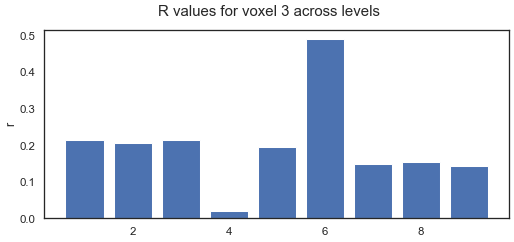

In [35]:
f, ax = plt.subplots(1,1, figsize = (12, 5), dpi=50)
f.suptitle(f'R values for voxel {3} across levels')
ax.bar(levels, r_levels_list, color='b', axes=ax);
ax.set_ylabel('r');

In [ ]:
plt.title(f'R values for voxel {top_V} across levels')
plt.bar(levels, r_levels_list, color='b');
plt.ylabel('r');

# Option 2. Computing the ROI's manually


http://nilearn.github.io/auto_examples/04_manipulating_images/plot_roi_extraction.html#sphx-glr-auto-examples-04-manipulating-images-plot-roi-extraction-py